ML ШИФТ

[JINT] (SHIFT-64009) Пашина Алёна

374

# Описание задачи

Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить 'таблетку'. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить, кому конкретно принадлежит 'след' прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько новых - не больше 10%).

'8 утра понедельник, турникет 4? Директор.' '11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.'  Какие есть паттерны в настоящих данных?

**Цель** - предсказать, кто вошел в здание по времени и турникету.

**Описание данных**

В обучающей выборке:

* `user_id` - ID посетителя
* `ts` - дата и время прохождения через турникет
* `gate_id` - ID турникета

В тестовой выборке `user_id` заменены на слова: `aucroc, binary, blue, categorical` и т.п.

Требуется составить таблицу вида:

| user_word | preds |
| --- | --- |
| aucroc | 50 |
| binary | 11 |
| blue | -999 |
| ... | ... |

* `user_word` - закодированные ID пользователей
* `preds` - предсказанные ID
* `-999` - ID нового посетителя, которого раньше не было

Таблицу нужно запомнить как `csv` и потом заархивировать в `zip` архив. 

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать ID. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее отгадали слово, тем больше баллов.

Посетителей здания будем считать сотрудниками некой компании.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (roc_auc_score, 
                             f1_score,
                             roc_curve, 
                             accuracy_score, 
                             ConfusionMatrixDisplay, 
                             confusion_matrix, 
                             recall_score,
                             precision_score)
from sklearn.inspection import permutation_importance
from catboost import (CatBoostClassifier,
                        Pool,
                        EShapCalcType,
                        EFeaturesSelectionAlgorithm)

import shap
import loguru
import plotly
import phik
import zipfile
import io
import re
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution
import optuna
from scipy.stats import mode

In [2]:
# sklearn.set_config(transform_output="pandas")
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

RANDOM_STATE = 42

In [3]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# Первичный анализ и предобработка данных

In [4]:
df_train = pd.read_csv('../data/train.csv', index_col=[0], parse_dates=[2])
df_test = pd.read_csv('../data/test.csv', index_col=[0], parse_dates=[1])
ex_submit = pd.read_csv('../data/submit.csv')

In [5]:
for name, df in zip(['тренировочная выборка', 'тестовая выборка', 'пример решения'], [df_train, df_test, ex_submit]):
    print(f'\033[1m{name}:\033[0m')
    display(df)
    print(f'\033[1mобщая информация - {name}:\033[0m')
    df.info()
    print(f'\033[1mколичество пропусков: {df.isna().sum().sum()}\033[0m')
    print(f'\033[1mколичество явных дубликатов: {df.duplicated().sum()}\033[0m')
    print()

тренировочная выборка:


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


общая информация - тренировочная выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB
количество пропусков: 0
количество явных дубликатов: 2346

тестовая выборка:


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


общая информация - тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB
количество пропусков: 0
количество явных дубликатов: 505

пример решения:


,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,12
7,epsilon,1
8,f1,37
9,fit,3


общая информация - пример решения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
количество пропусков: 0
количество явных дубликатов: 0



Пропусков в данных не обнаружено.

В тренировочной и тестовой выборке есть явные дубликаты, удалим их.

In [6]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

In [7]:
df_train.shape

(35172, 3)

In [8]:
df_test.shape

(6620, 3)

In [9]:
df_train.ts.agg([min, max]).to_frame()

,ts
min,2022-07-29 09:08:54
max,2022-12-31 20:39:31


In [10]:
df_test.ts.agg([min, max]).to_frame()

,ts
min,2023-01-03 08:21:00
max,2023-02-24 19:44:09


In [11]:
(df_test.ts.max() - df_train.ts.min()).days // 30

7

Предоставлены данные за 7 месяцев - с июля 2022 по фефраль 2023. Номер месяца в качестве признака не подойдет.

ID сотрудников

In [12]:
# id сотрудников в train
print(*sorted(df_train.user_id.unique()), sep=', ')
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57
Количество сотрудников в train: 56


In [13]:
# отсутствующие id
set(range(0, 58)) - set(df_train.user_id.unique())

{13, 16}

In [14]:
# активность сотрудников в train
count_user_id = df_train.user_id.value_counts(ascending=True).to_frame()

In [15]:
count_user_id.T

user_id,4,51,44,21,52,30,5,38,10,8,2,36,7,45,28,22,41,20,43,56,31,25,40,23,34,26,42,24,46,57,27,35,14,17,48,3,29,50,54,9,32,39,49,1,0,33,47,11,53,18,15,19,12,6,55,37
count,1,2,4,5,5,10,10,13,17,27,39,45,48,57,64,87,110,112,117,129,181,238,242,247,267,279,340,386,475,482,523,549,617,648,712,894,924,965,977,1015,1020,1032,1129,1171,1184,1184,1250,1255,1279,1441,1659,1661,1837,1857,2166,2184


Удалим неактивных сотрудников, количество проходов через турникеты которых менее 100. Поскольку это слишком маленькие категории для обучения (подбор гиперпараметров модели будет выполняться с помощью кроссвалидации), и, скорее всего, этих сотрудников нет в test.

In [16]:
len([0, 1, 2, 3, 6, 9, 11, 12, 14, 15, 17, 19, 23, 24, 25, 26, 29, 32, 33, 35, 37, 39, 43, 46, 49, 50, 54, 55, 56])

29

In [17]:
# delete_user_id = [4, 5, 7, 8, 10, 18, 20, 21, 22, 27, 28, 30, 31, 34, 36, 38, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 57]

In [18]:
27
18
31
48
8
47
36

36

In [19]:
# 8 и 41

In [20]:
delete_user_id = [4, 5, 7, 10, 18, 20, 21, 27, 28, 31, 30, 34, 38, 40, 42, 44, 45, 47, 48, 51, 52, 53, 57]
len(delete_user_id)

23

In [21]:
df_train = df_train[~df_train['user_id'].isin(delete_user_id)]
df_train.shape

(28107, 3)

In [22]:
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

Количество сотрудников в train: 33


In [23]:
df_train.user_id.value_counts(ascending=True).to_frame().T

user_id,8,2,36,22,41,43,56,25,23,26,24,46,35,14,17,3,29,50,54,9,32,39,49,1,0,33,11,15,19,12,6,55,37
count,27,39,45,87,110,117,129,238,247,279,386,475,549,617,648,894,924,965,977,1015,1020,1032,1129,1171,1184,1184,1255,1659,1661,1837,1857,2166,2184


In [24]:
print(f'Количество сотрудников в test: {len(df_test.user_word.unique())}')

Количество сотрудников в test: 34


In [25]:
# по условию сказано, что в тестовой выборке может быть не более 10% новых сотрудников
int(.1 * len(df_test.user_word.unique()))

3

In [26]:
# активность сотрудников в test
count_user_word = df_test.user_word.value_counts(ascending=True).to_frame()

In [27]:
count_user_word.T

user_word,logistic,blue,lasso,aucroc,regression,y,precision,coefficient,minimization,mse,target,distributed,ols,tstat,ridge,matrix,pvalue,fit,r2,linear,predict,recall,residual,categorical,gini,significant,independent,collinear,x,epsilon,binary,sigmoid,loss,f1
count,5,12,33,37,50,50,54,56,95,103,111,117,139,139,141,157,181,183,185,199,208,210,224,245,253,277,278,298,298,336,362,432,458,694


Турникеты

In [28]:
print(f'Количество турникетов в train: {len(df_train.gate_id.unique())}')
# частота использования турникетов в train
count_gate_id_train = df_train.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_train.T

Количество турникетов в train: 17


gate_id,14,0,16,1,8,-1,15,12,13,6,9,7,11,5,10,3,4
count,1,2,3,5,16,23,298,378,729,1309,1452,2412,3373,3732,3925,4033,6416


In [29]:
print(f'Количество турникетов в test: {len(df_test.gate_id.unique())}')
# частота использования турникетов в test
count_gate_id_test = df_test.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_test.T

Количество турникетов в test: 16


gate_id,14,-1,1,2,8,15,12,6,13,9,7,11,5,3,10,4
count,1,1,2,4,10,102,120,282,310,394,540,762,853,893,915,1431


In [30]:
# id турникетов, которые есть в train, но нет в test
set(df_train.gate_id.unique()) - set(df_test.gate_id.unique())

{0, 16}

In [31]:
# id турникетов, которые есть в test, но нет в train
set(df_test.gate_id.unique()) - set(df_train.gate_id.unique())

{2}

Поскольку `gate_id` мы будем использовать в качестве признака, редкие категории (менее 5 записей) нужно удалить.

In [32]:
delete_gate_id = set(count_gate_id_train.query('count < 5').index) | set(count_gate_id_test.query('count < 5').index)
delete_gate_id

{-1, 0, 1, 2, 14, 16}

In [33]:
df_train = df_train.query('gate_id not in @delete_gate_id').reset_index(drop=True)
df_test = df_test.query('gate_id not in @delete_gate_id').reset_index(drop=True)

In [34]:
df_test.shape

(6612, 3)

# Генерирование признаков

In [35]:
def make_features(df):
    df = df.loc[:]
    # отсортируем датафрейм для удобства генерирования признаков
    # потом отсортируем только по дате
    df = df.sort_values(['user_id', 'ts']).reset_index(drop=True)
    # временные признаки
    df['date'] = df.ts.dt.normalize()
    df['day_of_month'] = df.ts.dt.day
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    df['week_number'] = df.ts.dt.isocalendar().week             # неделя начинается с пн. Вспомогательный признак
    df['day_of_week'] = df.ts.dt.dayofweek                      # 0 = пн.
    df['is_weekend'] = df.day_of_week >= 5
    df['time_of_day'] = np.select(
            condlist=[df['hour'] < 6, df['hour'] < 12, df['hour'] < 18],
            choicelist=['night', 'morning', 'afternoon'],
            default='evening',
    )       # время суток
    df['is_month_start'] = df['ts'].dt.is_month_start
    df['is_month_end'] = df['ts'].dt.is_month_end

    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # число проходов сотрудником ч/з турникуты в день
    df['pass_cnt_per_day'] = grouped_data['gate_id'].transform('size')
    # число проходов через конкретный турникет в конкретный день
    df['daily_gate_pass_count'] = df.groupby(['user_id', 'date', 'gate_id'])['gate_id'].transform('size')
    # вероятность прохода через конкретный турникет в конкретный день
    df['probability_gate_id'] = df['daily_gate_pass_count'] / df['pass_cnt_per_day']
    # количество сотрудников, вошедших в конкретный день в здание
    df['cnt_users_per_day'] = df.groupby('date')['user_id'].transform('nunique')
    # количество сотрудников, вошедших в конкретную неделю в здание
    df['cnt_users_per_week'] = df.groupby('week_number')['user_id'].transform('nunique')
    # индекс дневной явки сотрудника
    df['daily_attendance_index'] = df['cnt_users_per_day'] / df['cnt_users_per_week']
    # количество дней в конкретную неделю, в которые сотрудник заходил в здание
    df['cnt_days_per_week'] = df.groupby(['user_id', 'week_number'])['date'].transform('nunique')

    # время прихода на работу (количество минут от полуночи)
    df['entry_time'] = grouped_data['ts'].transform('min')
    df['entry_time'] = ((df['entry_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # время ухода с работы (количество минут от полуночи)
    df['exit_time'] = grouped_data['ts'].transform('max')
    df['exit_time'] = ((df['exit_time'] - df['date']).dt.total_seconds() // 60).astype('int')   # Вспомогательный признак
    # продолжительность рабочего времени в минутах
    df['working_time_per_day'] = df['exit_time'] - df['entry_time']
    # турникет, через который сотрудник зашел в здание в конкретный день
    df['entrance_gate_id'] = grouped_data['gate_id'].transform('first')
    # турникет, через который сотрудник вышел из здания в конкретный день
    df['exit_gate_id'] = grouped_data['gate_id'].transform('last')
    # продолжительность рабочего времени за неделю в минутах (working_time_per_week)
    df_working_time_per_week = df.groupby(['user_id', 'date'], as_index=False)[['week_number', 'working_time_per_day']].first()
    df_working_time_per_week = df_working_time_per_week.groupby(['user_id', 'week_number'], as_index=False)['working_time_per_day'].sum()
    df_working_time_per_week = df_working_time_per_week.rename(columns={'working_time_per_day': 'working_time_per_week'})
    df = pd.merge(df, df_working_time_per_week, on=['user_id', 'week_number'], how='left')
    # индекс дневной нагрузки сотрудника - отношение минут работы за день к минутам работы за неделю
    df['daily_workload_index'] = df['working_time_per_day'] / df['working_time_per_week']
    # на случай, когда working_time_per_day = 0 и working_time_per_week = 0
    df['daily_workload_index'] = df['daily_workload_index'].fillna(0)

    for i in range(1, 6):
        # 5 предыдущих турникетов
        df[f'gate_id_lag_{i}'] = grouped_data['gate_id'].shift(i, fill_value=-100)
        # 5 последующих турникетов
        df[f'gate_id_{i}'] = grouped_data['gate_id'].shift(-i, fill_value=-200)
        # разница в секундах между текущей записью и пятью предыдущими
        df[f'sec_btw_lag_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(i)
        df[f'sec_btw_lag_{i}'] = df[f'sec_btw_lag_{i}'].fillna(-1000).astype('int')
        # разница в секундах между текущей записью и пятью следующими
        df[f'sec_btw_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(-i)
        df[f'sec_btw_{i}'] = df[f'sec_btw_{i}'].fillna(1000).astype('int')

    # метка gate_id, совпадающего с предыдущим, промежуток между срабатываниями равен 1 секунде
    df['repeat_gate_1s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(1)
    # -//- 2 секундам
    df['repeat_gate_2s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(2)
    # -//- 3 секундам
    df['repeat_gate_3s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(3)
    # -//- 4 секундам
    df['repeat_gate_4s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(4)
    # -//- от 5 секунд
    df['repeat_gate_ge_5s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].ge(5)
    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # количество повторных срабатываний турникетов для user_id в конкретный день, промежуток между срабатываниями равен 1 секунде
    df['cnt_repeat_gate_1s'] = grouped_data['repeat_gate_1s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_2s'] = grouped_data['repeat_gate_2s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_3s'] = grouped_data['repeat_gate_3s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_4s'] = grouped_data['repeat_gate_4s'].transform('sum')
    # -//- от 5 секунд
    df['cnt_repeat_gate_ge_5s'] = grouped_data['repeat_gate_ge_5s'].transform('sum')

    # маршрут – содержит информацию о соседних турникетах, через которые прошел сотрудник (направление не учитывается)
    df['route'] = df.apply(lambda row: str(sorted([row['gate_id_lag_1'], row['gate_id']])), axis=1)
    # если сотрудник пришел с улицы
    df.loc[df['route'].str.contains('-100'), 'route'] = 'not_route'

    # вспомогательный признак
    df['temp_sec_btw_lag_1'] = df['sec_btw_lag_1']
    # если сотрудник пришел с улицы
    df.loc[df['temp_sec_btw_lag_1'] < 0, 'temp_sec_btw_lag_1'] = 0
    # накопленное время нахождения в здании к моменту прохода через турникет в течение дня
    df['cumtime_per_day'] = df.groupby(['user_id', 'date'])['temp_sec_btw_lag_1'].cumsum()
    # накопленное время нахождения на конкретном маршруте в течение дня
    df['cumtime_at_route_per_day'] = df.groupby(['user_id', 'date', 'route'])['temp_sec_btw_lag_1'].cumsum()

    # самый часто используемый турникет за день
    df['most_frequent_gate_per_day'] = df.groupby(['user_id', 'date'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет за неделю
    df['most_frequent_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за день
    df['most_frequent_route_per_day'] = df.groupby(['user_id', 'date'])['route'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за неделю
    df['most_frequent_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform(lambda x: x.value_counts().idxmax())

    # среднее время, затраченное на маршрут в течение недели
    df['weekly_route_avg_time'] = df.groupby(['user_id', 'week_number', 'route'])['temp_sec_btw_lag_1'].transform('mean')
    # среднее время, затраченное на маршрут
    df['route_avg_time'] = df.groupby(['user_id', 'route'])['temp_sec_btw_lag_1'].transform('mean')

    return df

In [36]:
df_train = make_features(df_train)
df_train.head(3)

,user_id,ts,gate_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
0,0,2022-07-29 10:30:17,3,2022-07-29,29,10,630,37817,30,4,False,morning,False,False,12,4,0.33,17,17,1.00,1,630,1126,496,3,4,496,1.00,-100,3,-1000,-1,-100,11,-1000,-10144,-100,6,-1000,-10171,-100,6,-1000,-10172,-100,7,-1000,-13798,False,False,False,False,False,2,2,0,0,0,not_route,0,0,0,3,3,"[3, 3]","[3, 3]",0.00,0.00
1,0,2022-07-29 10:30:18,3,2022-07-29,29,10,630,37818,30,4,False,morning,False,False,12,4,0.33,17,17,1.00,1,630,1126,496,3,4,496,1.00,3,11,1,-10143,-100,6,-1000,-10170,-100,6,-1000,-10171,-100,7,-1000,-13797,-100,3,-1000,-13868,True,False,False,False,False,2,2,0,0,0,"[3, 3]",1,1,1,3,3,"[3, 3]","[3, 3]",1.50,1.92
2,0,2022-07-29 13:19:21,11,2022-07-29,29,13,799,47961,30,4,False,afternoon,False,False,12,2,0.17,17,17,1.00,1,630,1126,496,3,4,496,1.00,3,6,10143,-27,3,6,10144,-28,-100,7,-1000,-3654,-100,3,-1000,-3725,-100,3,-1000,-3727,False,False,False,False,False,2,2,0,0,0,"[3, 11]",10143,10144,10143,3,3,"[3, 3]","[3, 3]","10,143.00","12,404.29"


In [37]:
df_train.shape

(28073, 68)

In [38]:
# временно переименуем колонку `user_word` на `user_id`
df_test = df_test.rename(columns={'user_word': 'user_id'})

df_test = make_features(df_test)
# df_test = df_test.rename(columns={'user_id': 'user_word'})
df_test.head(3)

,ts,gate_id,user_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
0,2023-01-04 11:07:00,15,aucroc,2023-01-04,4,11,667,40020,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,667,1103,436,15,15,632,0.69,-100,9,-1000,-164,-100,5,-1000,-174,-100,5,-1000,-175,-100,10,-1000,-192,-100,11,-1000,-25885,False,False,False,False,False,1,1,0,0,0,not_route,0,0,0,15,5,not_route,not_route,0.00,0.00
1,2023-01-04 11:09:44,9,aucroc,2023-01-04,4,11,669,40184,1,2,False,morning,False,False,9,1,0.11,21,27,0.78,2,667,1103,436,15,15,632,0.69,15,5,164,-10,-100,5,-1000,-11,-100,10,-1000,-28,-100,11,-1000,-25721,-100,4,-1000,-25746,False,False,False,False,False,1,1,0,0,0,"[9, 15]",164,164,164,15,5,not_route,not_route,164.00,211.33
2,2023-01-04 11:09:54,5,aucroc,2023-01-04,4,11,669,40194,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,667,1103,436,15,15,632,0.69,9,5,10,-1,15,10,174,-18,-100,11,-1000,-25711,-100,4,-1000,-25736,-100,4,-1000,-25738,False,False,False,False,False,1,1,0,0,0,"[5, 9]",10,174,10,15,5,not_route,not_route,14.50,14.50


In [39]:
df_test.shape

(6612, 68)

In [40]:
df_train.isna().sum().sum()

0

In [41]:
df_test.isna().sum().sum()

0

# Исследовательский анализ данных

## Повторное срабатывание турникетов

## Количество проходов через турникеты в неделю

In [42]:
week_counts_train = df_train['week_number'].value_counts().sort_index().reset_index()

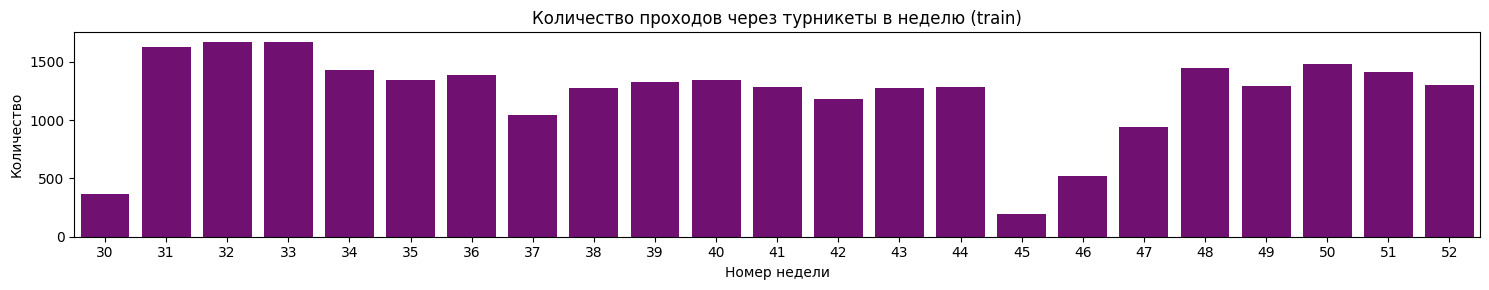

In [43]:
plt.figure(figsize=(15, 3))
sns.barplot(x='week_number', y='count', data=week_counts_train, color='purple')
plt.title('Количество проходов через турникеты в неделю (train)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [44]:
df_train.loc[df_train['week_number'] == 30, 'date'].nunique()

3

In [45]:
df_train.loc[df_train['week_number'] == 45, 'date'].nunique()

3

In [46]:
df_train.loc[df_train['week_number'] == 45, 'user_id'].unique()

array([ 0,  1,  6, 12, 14, 15, 17, 32, 35, 37, 46, 49, 50, 54],
      dtype=int64)

Мы видим, что 30 неделя - неполная. Поскольку при генерировании признаков мы использовали агрегацию по номеру недели, удалим данные за 30 неделю из тренировочной выборки.

In [47]:
df_train.shape

(28073, 68)

In [48]:
df_train = df_train.query('week_number > 30 and week_number != 45').reset_index(drop=True)
df_train.shape

(27515, 68)

In [49]:
# df_train = df_train.query('week_number > 30').reset_index(drop=True)
# df_train.shape

In [50]:
df_train['user_id'].nunique()

33

In [51]:
week_counts_test = df_test['week_number'].value_counts().sort_index().reset_index()

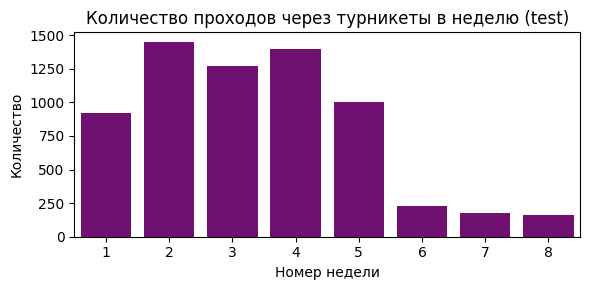

In [52]:
plt.figure(figsize=(6, 3))
sns.barplot(x='week_number', y='count', data=week_counts_test, color='purple')
plt.title('Количество проходов через турникеты в неделю (test)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [53]:
df_test.loc[df_test['week_number'] == 1, 'date'].nunique()

5

In [54]:
df_test.loc[df_test['week_number'] == 8, 'date'].nunique()

5

In [55]:
df_test.query('week_number >= 6')['user_id'].nunique()

20

Удалим из тестовой выборки данные с 6 по 8 неделю, поскольку в этот период была маленькая активность.

In [56]:
df_test.shape

(6612, 68)

In [57]:
df_test = df_test.query('week_number < 6').reset_index(drop=True)
df_test.shape

(6040, 68)

In [58]:
df_test['user_id'].nunique()

34

In [59]:
df_train = df_train.sort_values('ts').reset_index(drop=True)
df_test = df_test.sort_values('ts').reset_index(drop=True)

In [60]:
# удаление вспомогательных признаков
df_train = df_train.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)
df_test = df_test.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27515 entries, 0 to 27514
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       27515 non-null  int64  
 1   gate_id                       27515 non-null  int64  
 2   day_of_month                  27515 non-null  int32  
 3   hour                          27515 non-null  int32  
 4   total_minutes                 27515 non-null  int32  
 5   total_seconds                 27515 non-null  int32  
 6   day_of_week                   27515 non-null  int32  
 7   is_weekend                    27515 non-null  bool   
 8   time_of_day                   27515 non-null  object 
 9   is_month_start                27515 non-null  bool   
 10  is_month_end                  27515 non-null  bool   
 11  pass_cnt_per_day              27515 non-null  int64  
 12  daily_gate_pass_count         27515 non-null  int64  
 13  p

In [62]:
df_train.columns

Index(['user_id', 'gate_id', 'day_of_month', 'hour', 'total_minutes',
       'total_seconds', 'day_of_week', 'is_weekend', 'time_of_day',
       'is_month_start', 'is_month_end', 'pass_cnt_per_day',
       'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day',
       'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week',
       'entry_time', 'working_time_per_day', 'entrance_gate_id',
       'exit_gate_id', 'working_time_per_week', 'daily_workload_index',
       'gate_id_lag_1', 'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1',
       'gate_id_lag_2', 'gate_id_2', 'sec_btw_lag_2', 'sec_btw_2',
       'gate_id_lag_3', 'gate_id_3', 'sec_btw_lag_3', 'sec_btw_3',
       'gate_id_lag_4', 'gate_id_4', 'sec_btw_lag_4', 'sec_btw_4',
       'gate_id_lag_5', 'gate_id_5', 'sec_btw_lag_5', 'sec_btw_5',
       'repeat_gate_1s', 'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s',
       'repeat_gate_ge_5s', 'cnt_repeat_gate_1s', 'cnt_repeat_gate_2s',
       'cnt_repeat_gate_3s

In [138]:
categorical_features = [
       'gate_id', 'day_of_month', 'hour',
       'day_of_week', 'is_weekend', 'time_of_day', 
       'is_month_start', 'is_month_end', 'entrance_gate_id', 
       'exit_gate_id', 'gate_id_lag_1', 'gate_id_1',
       'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3',
       'gate_id_3', 'gate_id_lag_4', 'gate_id_4',
       'gate_id_lag_5', 'gate_id_5', 'repeat_gate_1s',
       'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s',
       'repeat_gate_ge_5s', 'route', 'most_frequent_gate_per_day',
       'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week'
]

## Оценка важности признаков

### Корреляция между признаками

In [64]:
# %%time
# phik_overview = df_train.phik_matrix().round(2).sort_values('user_id', ascending=False)
# phik_overview

In [65]:
# # отберем фичи, у которых корреляция с целевым признаком более 0.2
# df_train = df_train[phik_overview[phik_overview['user_id'] > 0.2].index]

In [66]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(phik_overview, vmin=0, vmax=1, cmap='Purples', annot=True, linewidths=0.1, fmt='.2f')
# plt.suptitle('Матрица Phi_K-корреляций', y=0.92);

In [67]:
# %%time
# significance_overview = df_train.significance_matrix().fillna(0).round(1).sort_values('user_id', ascending=False)
# significance_overview

In [68]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(significance_overview, vmin=-5, vmax=5, cmap='Purples', annot=True, linewidths=0.1, fmt='.1f')
# plt.suptitle('Значимость коэффициентов', y=0.92);

# Построение моделей

## Разделение исходных данных на выборки

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27515 entries, 0 to 27514
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       27515 non-null  int64  
 1   gate_id                       27515 non-null  int64  
 2   day_of_month                  27515 non-null  int32  
 3   hour                          27515 non-null  int32  
 4   total_minutes                 27515 non-null  int32  
 5   total_seconds                 27515 non-null  int32  
 6   day_of_week                   27515 non-null  int32  
 7   is_weekend                    27515 non-null  bool   
 8   time_of_day                   27515 non-null  object 
 9   is_month_start                27515 non-null  bool   
 10  is_month_end                  27515 non-null  bool   
 11  pass_cnt_per_day              27515 non-null  int64  
 12  daily_gate_pass_count         27515 non-null  int64  
 13  p

In [70]:
y = df_train['user_id']
X = df_train.drop(['user_id'], axis=1)

In [71]:
# categorical_columns = categorical_features
# print(categorical_columns)

In [72]:
# len(categorical_columns)

In [73]:
# numerical_columns = list(set(X.columns) - set(categorical_columns))
# print(numerical_columns)

In [74]:
# len(numerical_columns)

In [75]:
# X = X[categorical_columns + numerical_columns]

In [76]:
# # формируем массив индексов категориальных признаков
# categorical_features_indices = list(range(len(categorical_columns)))
# print(categorical_features_indices)

In [77]:
# выделение обучающей выборки (80 %) и тестовой (20 %)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y
)

In [78]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22012, 62), (5503, 62), (22012,), (5503,))

In [79]:
y_train.nunique()

33

In [80]:
print(sorted(y_train.unique()))

[0, 1, 2, 3, 6, 8, 9, 11, 12, 14, 15, 17, 19, 22, 23, 24, 25, 26, 29, 32, 33, 35, 36, 37, 39, 41, 43, 46, 49, 50, 54, 55, 56]


In [81]:
y_test.nunique()

33

In [82]:
print(sorted(y_test.unique()))

[0, 1, 2, 3, 6, 8, 9, 11, 12, 14, 15, 17, 19, 22, 23, 24, 25, 26, 29, 32, 33, 35, 36, 37, 39, 41, 43, 46, 49, 50, 54, 55, 56]


## Подбор гиперпараметров

In [83]:
def fit_catboost(trial, train, val, cat_features_indices):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'n_estimators' : 2000, # Можно не перебирать, есть Early-Stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 60.0),        
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'None']),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'border_count': trial.suggest_int('border_count', 32, 128)
    }

    clf = CatBoostClassifier(
        **param,
        loss_function='MultiClass',
        eval_metric='TotalF1:average=Macro',
        random_seed=RANDOM_STATE,
        cat_features=cat_features_indices,
        thread_count=-1,
        task_type='GPU',
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=100,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [84]:
def objective(trial, X, y, cat_features_indices, return_models=False):
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scores, models = [], []
    
    for train_idx, valid_idx in skf.split(X, y):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data, cat_features_indices) # Определили выше
        scores.append(f1_score(valid_data[1], y_pred, average='macro'))
        models.append(model)
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result

In [85]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X, y, categorical_features),
                n_trials=3,
                show_progress_bar=True,
)

[I 2024-08-16 18:16:43,434] A new study created in memory with name: no-name-a88180a7-824a-495e-95bc-6dc31add3078


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.2606482	test: 0.2593489	best: 0.2593489 (0)	total: 91.8ms	remaining: 3m 3s
100:	learn: 0.5536750	test: 0.5555023	best: 0.5555023 (100)	total: 8.37s	remaining: 2m 37s
200:	learn: 0.7433961	test: 0.7215110	best: 0.7225690 (199)	total: 16.7s	remaining: 2m 29s
300:	learn: 0.8138344	test: 0.7991717	best: 0.7991717 (300)	total: 24.6s	remaining: 2m 18s
400:	learn: 0.8749451	test: 0.8504557	best: 0.8504696 (399)	total: 31.7s	remaining: 2m 6s
500:	learn: 0.9197323	test: 0.9045497	best: 0.9045662 (498)	total: 39.1s	remaining: 1m 57s
600:	learn: 0.9479254	test: 0.9282599	best: 0.9282979 (596)	total: 46.3s	remaining: 1m 47s
700:	learn: 0.9586096	test: 0.9409278	best: 0.9410093 (699)	total: 53.4s	remaining: 1m 38s
800:	learn: 0.9646410	test: 0.9495787	best: 0.9496471 (798)	total: 1m	remaining: 1m 30s
900:	learn: 0.9706787	test: 0.9549787	best: 0.9549787 (900)	total: 1m 7s	remaining: 1m 22s
1000:	learn: 0.9743751	test: 0.9576491	best: 0.9576491 (999)	total: 1m 14s	remaining: 1m 13s
1100:

In [86]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9982813153647968, params {'learning_rate': 0.0769727755879644, 'l2_leaf_reg': 8.216801603031977, 'auto_class_weights': 'None', 'max_depth': 6, 'border_count': 73}


In [87]:
%%time

valid_scores, models_all_features = objective(
    optuna.trial.FixedTrial(study.best_params),
    X, 
    y, 
    categorical_features,
    return_models=True,
)

0:	learn: 0.2190609	test: 0.2157486	best: 0.2157486 (0)	total: 117ms	remaining: 3m 53s
100:	learn: 0.8986821	test: 0.8825366	best: 0.8825366 (100)	total: 10.5s	remaining: 3m 18s
200:	learn: 0.9751459	test: 0.9562846	best: 0.9562846 (200)	total: 20.4s	remaining: 3m 2s
300:	learn: 0.9814369	test: 0.9677286	best: 0.9680143 (295)	total: 29.8s	remaining: 2m 48s
400:	learn: 0.9858355	test: 0.9787608	best: 0.9799704 (398)	total: 39.1s	remaining: 2m 36s
500:	learn: 0.9894641	test: 0.9829720	best: 0.9829720 (497)	total: 48.4s	remaining: 2m 24s
600:	learn: 0.9933671	test: 0.9848480	best: 0.9848515 (594)	total: 57.8s	remaining: 2m 14s
700:	learn: 0.9952037	test: 0.9869114	best: 0.9869742 (675)	total: 1m 7s	remaining: 2m 4s
800:	learn: 0.9967420	test: 0.9893864	best: 0.9893864 (795)	total: 1m 16s	remaining: 1m 55s
900:	learn: 0.9986774	test: 0.9908256	best: 0.9909370 (898)	total: 1m 26s	remaining: 1m 45s
1000:	learn: 0.9994302	test: 0.9937728	best: 0.9937728 (999)	total: 1m 36s	remaining: 1m 35s
1

In [88]:
models_all_features

In [89]:
valid_scores, len(models_all_features)

(0.9982813153647968, 3)

In [90]:
for m in models_all_features:
    print(m.tree_count_)

1527
1251
1288


In [91]:
for m in models_all_features:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 8.216801643371582, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage

## Важность признаков

### Feature Importance

In [167]:
# models_all_features[1].get_feature_importance(prettified=True)

In [119]:
# feature_importance = models_all_features[1].feature_importances_
# sorted_idx = np.argsort(feature_importance)

In [105]:
# plt.figure(figsize=(15, 15))
# plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx], color='skyblue')
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.title('Feature Importance in CatBoostClassifier')
# plt.grid(axis='x', linestyle='--', linewidth=0.7)

### SHAP values

## Отбор признаков

In [102]:
# создаем список имен признаков
feature_names = list(X_train.columns)


# создаем обучающий и проверочный пулы
train_pool = Pool(X_train, 
                  y_train,
                  feature_names=feature_names, 
                  cat_features=categorical_features)

test_pool = Pool(X_test, 
                 y_test, 
                 feature_names=feature_names, 
                 cat_features=categorical_features)

In [103]:
study.best_params

{'learning_rate': 0.0769727755879644,
 'l2_leaf_reg': 8.216801603031977,
 'auto_class_weights': 'None',
 'max_depth': 6,
 'border_count': 73}

In [104]:
# пишем функцию отбора признаков на основе 
# рекурсивного удаления признаков
def catboost_select_features(
    algorithm: EFeaturesSelectionAlgorithm, 
    steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(
                    **study.best_params,
                    n_estimators=1400,
                    random_seed=RANDOM_STATE,
                    loss_function='MultiClass',
                    eval_metric='TotalF1:average=Macro',
                    thread_count=-1,
                    task_type='GPU'
    )
    summary = model.select_features(
        # обучающий пул
        train_pool,
        # проверочный пул
        eval_set=test_pool,
        # список признаков, участвующих в отборе
        features_for_select=list(range(train_pool.num_col())),
        # количество отбираемых признаков
        num_features_to_select=3,
        # количество итераций обучения модели, вычисляющей 
        # оценки важностей (чем больше, тем лучше качество)
        steps=steps,
        # алгоритм отбора
        algorithm=algorithm,
        # метод вычисления значений SHAP
        shap_calc_type=EShapCalcType.Regular,
        # обучаем модель с отобранными признаками
        train_final_model=True,
        # уровень детализации вывода
        logging_level='Silent',
        # отрисовка кривых обучения и валидации
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [105]:
%%time

# выполняем отбор признаков
shap_summary = catboost_select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
    steps=5
)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['entry_time', 'working_time_per_week', 'most_frequent_route_per_week']
CPU times: total: 28min 35s
Wall time: 12min 21s


In [106]:
print(shap_summary['loss_graph'])

{'main_indices': [0, 28, 44, 52, 57, 59], 'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 'loss_values': [0.061350654661992014, 0.06315717086131735, 0.0631571708613175, 0.0631571708613175, 0.06315717086131782, 0.06315717086131782, 0.06315717086131782, 0.06315717086131782, 0.06306265417793575, 0.062898514247475, 0.06273357299014315, 0.06247217050690329, 0.06219828411627583, 0.061887953490978545, 0.06157501267477719, 0.06123118519757982, 0.06083757001841402, 0.06038564490325236, 0.05990119815279373, 0.059390230369066016, 0.05878974798891861, 0.058155989576013215, 0.057505131150421135, 0.05659791292547568, 0.05535985570194032, 0.054118461564382214, 0.05280684901226633, 0.05101684179540017, 0.0491496936840524, 0.04916007242853885, 0.0491718513417819, 0.04918428273904506, 0.0492020622

In [107]:
shap_summary['loss_graph']['loss_values'][-1]

0.1490967258949292

In [108]:
# печатаем отобранные признаки
selected_feat = shap_summary['selected_features_names']
print(selected_feat)

['entry_time', 'working_time_per_week', 'most_frequent_route_per_week']


In [109]:
# печатаем исключенные признаки
eliminated_feat = shap_summary['eliminated_features_names']
print(eliminated_feat)

['sec_btw_lag_1', 'gate_id_lag_3', 'gate_id_lag_5', 'repeat_gate_1s', 'repeat_gate_3s', 'repeat_gate_4s', 'route', 'gate_id_2', 'gate_id_3', 'repeat_gate_2s', 'sec_btw_lag_5', 'repeat_gate_ge_5s', 'cumtime_at_route_per_day', 'daily_gate_pass_count', 'gate_id_lag_4', 'gate_id', 'sec_btw_5', 'gate_id_4', 'gate_id_5', 'sec_btw_lag_4', 'is_month_end', 'time_of_day', 'total_minutes', 'hour', 'day_of_month', 'gate_id_1', 'gate_id_lag_2', 'sec_btw_4', 'sec_btw_lag_2', 'gate_id_lag_1', 'is_month_start', 'is_weekend', 'sec_btw_3', 'sec_btw_lag_3', 'cumtime_per_day', 'sec_btw_1', 'total_seconds', 'weekly_route_avg_time', 'sec_btw_2', 'probability_gate_id', 'cnt_repeat_gate_4s', 'day_of_week', 'cnt_repeat_gate_ge_5s', 'cnt_users_per_day', 'cnt_repeat_gate_3s', 'most_frequent_gate_per_day', 'cnt_repeat_gate_2s', 'daily_attendance_index', 'most_frequent_route_per_day', 'daily_workload_index', 'exit_gate_id', 'route_avg_time', 'cnt_repeat_gate_1s', 'entrance_gate_id', 'working_time_per_day', 'pass_c

На основе графика `Loss by eliminated features`, отберем из списка `eliminated_feat` фичи, начиная с 44-го индекса.

In [111]:
selected_features = selected_feat + eliminated_feat[28:]
selected_features

['entry_time',
 'working_time_per_week',
 'most_frequent_route_per_week',
 'sec_btw_lag_2',
 'gate_id_lag_1',
 'is_month_start',
 'is_weekend',
 'sec_btw_3',
 'sec_btw_lag_3',
 'cumtime_per_day',
 'sec_btw_1',
 'total_seconds',
 'weekly_route_avg_time',
 'sec_btw_2',
 'probability_gate_id',
 'cnt_repeat_gate_4s',
 'day_of_week',
 'cnt_repeat_gate_ge_5s',
 'cnt_users_per_day',
 'cnt_repeat_gate_3s',
 'most_frequent_gate_per_day',
 'cnt_repeat_gate_2s',
 'daily_attendance_index',
 'most_frequent_route_per_day',
 'daily_workload_index',
 'exit_gate_id',
 'route_avg_time',
 'cnt_repeat_gate_1s',
 'entrance_gate_id',
 'working_time_per_day',
 'pass_cnt_per_day',
 'cnt_users_per_week',
 'cnt_days_per_week',
 'most_frequent_gate_per_week']

In [112]:
len(selected_features)

34

In [114]:
cat_features = [
    'most_frequent_route_per_week',
    'gate_id_lag_1',
    'is_month_start',
    'is_weekend',
    'day_of_week',
    'most_frequent_gate_per_day',
    'most_frequent_route_per_day',
    'exit_gate_id',
    'entrance_gate_id',
    'most_frequent_gate_per_week'
]

In [115]:
%%time

valid_scores, models_selected_features = objective(
    optuna.trial.FixedTrial(study.best_params),
    X[selected_features], 
    y, 
    cat_features,
    return_models=True,
)

0:	learn: 0.1660224	test: 0.1708891	best: 0.1708891 (0)	total: 70.6ms	remaining: 2m 21s
100:	learn: 0.8953478	test: 0.8748655	best: 0.8748655 (100)	total: 5s	remaining: 1m 34s
200:	learn: 0.9707850	test: 0.9520451	best: 0.9520451 (200)	total: 9.57s	remaining: 1m 25s
300:	learn: 0.9863208	test: 0.9758638	best: 0.9758638 (298)	total: 13.9s	remaining: 1m 18s
400:	learn: 0.9926128	test: 0.9827912	best: 0.9827912 (400)	total: 18s	remaining: 1m 11s
500:	learn: 0.9960834	test: 0.9881939	best: 0.9882308 (495)	total: 22.2s	remaining: 1m 6s
600:	learn: 0.9970571	test: 0.9896676	best: 0.9896676 (599)	total: 26.5s	remaining: 1m 1s
700:	learn: 0.9981323	test: 0.9910722	best: 0.9910722 (696)	total: 30.7s	remaining: 56.9s
800:	learn: 0.9991502	test: 0.9940013	best: 0.9940688 (790)	total: 34.9s	remaining: 52.3s
900:	learn: 0.9997263	test: 0.9956091	best: 0.9956766 (890)	total: 39.2s	remaining: 47.8s
1000:	learn: 0.9998109	test: 0.9970440	best: 0.9970440 (990)	total: 43.5s	remaining: 43.4s
1100:	learn:

In [116]:
valid_scores

0.9980449950872896

In [117]:
for m in models_selected_features:
    print(m.tree_count_)

1288
1080
940


In [118]:
for m in models_selected_features:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 8.216801643371582, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage

## Подбор гиперпараметров после отбора признаков

In [127]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X[selected_features], y, cat_features),
                n_trials=3,
                show_progress_bar=True,
)

[I 2024-08-16 19:57:33,094] A new study created in memory with name: no-name-b1c855e6-c920-43fc-985d-7dce42b03037


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.1158024	test: 0.1173108	best: 0.1173108 (0)	total: 35.8ms	remaining: 1m 11s
100:	learn: 0.5586758	test: 0.5570482	best: 0.5570482 (100)	total: 2.98s	remaining: 55.9s
200:	learn: 0.6465937	test: 0.6469918	best: 0.6469918 (200)	total: 5.92s	remaining: 53s
300:	learn: 0.7405274	test: 0.7363120	best: 0.7363306 (299)	total: 8.86s	remaining: 50s
400:	learn: 0.7851284	test: 0.7764509	best: 0.7764509 (400)	total: 11.7s	remaining: 46.7s
500:	learn: 0.8137674	test: 0.8064561	best: 0.8069580 (495)	total: 14.6s	remaining: 43.6s
600:	learn: 0.8318686	test: 0.8262388	best: 0.8262388 (600)	total: 17.5s	remaining: 40.8s
700:	learn: 0.8491159	test: 0.8444259	best: 0.8449423 (698)	total: 20.4s	remaining: 37.8s
800:	learn: 0.8617079	test: 0.8543384	best: 0.8543384 (800)	total: 23.2s	remaining: 34.8s
900:	learn: 0.8716488	test: 0.8675375	best: 0.8675375 (900)	total: 26.1s	remaining: 31.8s
1000:	learn: 0.8841551	test: 0.8788279	best: 0.8789275 (998)	total: 28.9s	remaining: 28.9s
1100:	learn: 0.

In [128]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9953547190938936, params {'learning_rate': 0.09816883769920995, 'l2_leaf_reg': 54.63988329368241, 'auto_class_weights': 'None', 'max_depth': 10, 'border_count': 115}


In [130]:
%%time

valid_scores, models_sf_new_fit = objective(
    optuna.trial.FixedTrial(study.best_params),
    X[selected_features], 
    y, 
    cat_features,
    return_models=True,
)

0:	learn: 0.3864876	test: 0.3844690	best: 0.3844690 (0)	total: 340ms	remaining: 11m 20s
100:	learn: 0.7529086	test: 0.7356702	best: 0.7356702 (100)	total: 29.4s	remaining: 9m 13s
200:	learn: 0.8848241	test: 0.8662362	best: 0.8662362 (200)	total: 59.1s	remaining: 8m 48s
300:	learn: 0.9411259	test: 0.9273788	best: 0.9273788 (300)	total: 1m 28s	remaining: 8m 18s
400:	learn: 0.9661965	test: 0.9510845	best: 0.9510845 (398)	total: 1m 56s	remaining: 7m 43s
500:	learn: 0.9868048	test: 0.9736080	best: 0.9737023 (495)	total: 2m 39s	remaining: 7m 55s
600:	learn: 0.9917324	test: 0.9835485	best: 0.9835485 (600)	total: 3m 21s	remaining: 7m 50s
700:	learn: 0.9959598	test: 0.9931528	best: 0.9931528 (696)	total: 4m 5s	remaining: 7m 34s
800:	learn: 0.9968471	test: 0.9943142	best: 0.9943225 (760)	total: 4m 50s	remaining: 7m 14s
bestTest = 0.9943224513
bestIteration = 760
Shrink model to first 761 iterations.
0:	learn: 0.3834364	test: 0.3733063	best: 0.3733063 (0)	total: 486ms	remaining: 16m 11s
100:	lear

In [ ]:
valid_scores

0.9987588005955305

In [ ]:
for m in models_sf_new_fit:
    print(m.tree_count_)

687
539
882


In [ ]:
for m in models_sf_new_fit:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 18.33833122253418, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage

## Итоговое предсказание лучшей модели

In [92]:
def make_prediction_dict(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    result = result.groupby('user_word')['pred_user_id'].agg(lambda group: dict(group.value_counts())).to_dict()
    return result

In [93]:
def make_prediction(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    # датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id для конкретной категории user_word
    temp_1 = result.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
    # датафрейм: user_word; количество user_word
    temp_2 = result['user_word'].value_counts().reset_index(name='count_user_word')
    # датафрейм: pred_user_id; количество pred_user_id
    temp_3 = result['pred_user_id'].value_counts().reset_index(name='count_pred_user_id')
    # датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word; count_pred_user_id
    result = temp_1.merge(temp_2, on='user_word', how='left').merge(temp_3, on='pred_user_id', how='left')
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во user_word
    result['confidence_per_user_word'] = result['count_pred_user_id_in_user_word'] / result['count_user_word']
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во pred_user_id
    result['confidence_per_pred_user_id'] = result['count_pred_user_id_in_user_word'] / result['count_pred_user_id']
    # итоговая уверенность
    result['confidence'] = result['confidence_per_user_word'] + result['confidence_per_pred_user_id']
    # сортируем данные по убыванию уверенности
    result = result.sort_values(by='confidence', ascending=False)

    # формируем итоговый датафрейм
    final = pd.DataFrame(columns=['user_word', 'preds'])
    # user_word, которые уже добавлены в final
    words = set()
    # user_id, которые уже добавлены в final
    ids = set()
    # добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
    for _, row in result.iterrows():
        word, user_id = row['user_word'], row['pred_user_id']
        if word not in words and user_id not in ids and row['confidence'] > 0.1:
            final.loc[len(final)] = [word, user_id]
            words.add(word)
            ids.add(user_id)

    # категориям, насчет которых модель не уверена, проставляется -999
    for word in (set(result['user_word'].unique()) - set(final['user_word'])):
        final.loc[len(final)] = [word, -999]
    
    return final.sort_values(by='user_word')

In [94]:
df_test = df_test.rename(columns={'user_id': 'user_word'})

Сделаем предсказание

Используем все фичи

In [95]:
result_dct = make_prediction_dict(df_test, X.columns, models_all_features)
result_dct

{'aucroc': {24: 33, 14: 2},
 'binary': {12: 249, 14: 40, 29: 18, 9: 15, 49: 7},
 'blue': {25: 12},
 'categorical': {14: 170, 12: 1},
 'coefficient': {15: 47, 22: 9},
 'collinear': {46: 50,
  33: 50,
  43: 34,
  54: 30,
  6: 27,
  35: 20,
  55: 14,
  0: 12,
  17: 5,
  37: 3,
  23: 3,
  29: 2,
  50: 2},
 'distributed': {0: 89, 24: 14, 11: 13, 35: 1},
 'epsilon': {1: 171, 49: 96, 26: 20, 15: 16},
 'f1': {6: 537, 37: 91, 1: 5},
 'fit': {15: 79,
  23: 39,
  35: 9,
  0: 9,
  11: 8,
  43: 8,
  1: 7,
  50: 6,
  2: 5,
  46: 5,
  3: 3,
  39: 2,
  17: 2,
  33: 1},
 'gini': {15: 164, 0: 8, 1: 7, 39: 7},
 'independent': {39: 114,
  14: 35,
  15: 27,
  49: 22,
  46: 16,
  12: 9,
  1: 7,
  25: 2,
  35: 1,
  23: 1},
 'lasso': {46: 13, 56: 9, 25: 6, 23: 5},
 'linear': {17: 60, 55: 44, 0: 39, 33: 34, 3: 12, 32: 10},
 'logistic': {25: 5},
 'loss': {19: 384, 15: 33, 11: 15, 46: 10, 54: 4, 12: 1},
 'matrix': {29: 29,
  32: 21,
  25: 16,
  55: 16,
  11: 13,
  49: 9,
  15: 8,
  35: 8,
  43: 6,
  37: 5,
  23:

In [96]:
result_cb = make_prediction(df_test, X.columns, models_all_features)
result_cb

,user_word,preds
2,aucroc,24
5,binary,12
11,blue,25
3,categorical,14
26,coefficient,22
32,collinear,-999
12,distributed,0
8,epsilon,1
1,f1,6
16,fit,2


In [97]:
len(result_cb)

34

После удаления фичей, уменьшающих скор

In [119]:
result_dct_sf = make_prediction_dict(df_test, selected_features, models_selected_features)
result_dct_sf

{'aucroc': {24: 35},
 'binary': {12: 258, 14: 29, 29: 18, 9: 16, 49: 8},
 'blue': {25: 12},
 'categorical': {14: 170, 12: 1},
 'coefficient': {15: 47, 22: 9},
 'collinear': {33: 50,
  46: 44,
  43: 35,
  54: 30,
  6: 27,
  35: 27,
  55: 13,
  0: 7,
  17: 5,
  50: 4,
  37: 3,
  29: 3,
  1: 2,
  23: 2},
 'distributed': {0: 84, 11: 17, 24: 14, 50: 1, 35: 1},
 'epsilon': {1: 149, 49: 113, 26: 25, 15: 16},
 'f1': {6: 553, 37: 75, 1: 5},
 'fit': {15: 78,
  23: 35,
  0: 13,
  11: 12,
  2: 12,
  39: 7,
  43: 6,
  50: 6,
  1: 5,
  46: 5,
  54: 2,
  17: 1,
  19: 1},
 'gini': {15: 153, 39: 20, 0: 8, 1: 5},
 'independent': {39: 116, 14: 35, 49: 27, 1: 19, 46: 14, 15: 10, 12: 7, 25: 6},
 'lasso': {46: 14, 25: 9, 56: 5, 23: 5},
 'linear': {17: 62, 55: 47, 33: 36, 0: 31, 3: 15, 32: 8},
 'logistic': {25: 5},
 'loss': {19: 379, 15: 33, 11: 13, 46: 12, 54: 10},
 'matrix': {29: 33,
  32: 27,
  55: 15,
  11: 13,
  25: 9,
  15: 8,
  35: 8,
  49: 7,
  2: 7,
  41: 2,
  37: 2,
  23: 1},
 'minimization': {50: 

In [120]:
result_cb_sf = make_prediction(df_test, selected_features, models_selected_features)
result_cb_sf

,user_word,preds
1,aucroc,24
5,binary,12
12,blue,25
3,categorical,14
25,coefficient,22
32,collinear,-999
15,distributed,0
11,epsilon,1
0,f1,6
23,fit,2


In [121]:
len(result_cb_sf)

34

После удаления фичей, уменьшающих скор, и повторного подбора гиперпараметров

In [131]:
result_dct_sf_new_fit = make_prediction_dict(df_test, selected_features, models_sf_new_fit)
result_dct_sf_new_fit

{'aucroc': {24: 35},
 'binary': {12: 250, 14: 25, 9: 20, 29: 18, 43: 8, 49: 8},
 'blue': {24: 12},
 'categorical': {14: 152, 24: 18, 12: 1},
 'coefficient': {15: 37, 24: 16, 46: 3},
 'collinear': {43: 55,
  0: 42,
  33: 38,
  46: 38,
  37: 21,
  6: 16,
  35: 13,
  29: 9,
  50: 6,
  17: 5,
  3: 5,
  1: 4},
 'distributed': {0: 61, 26: 14, 19: 13, 11: 12, 24: 12, 55: 5},
 'epsilon': {49: 112, 1: 79, 15: 57, 55: 17, 3: 17, 26: 14, 29: 7},
 'f1': {6: 479, 37: 143, 1: 5, 3: 4, 49: 2},
 'fit': {15: 54,
  23: 43,
  1: 24,
  2: 24,
  0: 16,
  43: 8,
  3: 4,
  33: 4,
  19: 4,
  50: 2},
 'gini': {15: 133, 1: 23, 39: 14, 49: 8, 0: 8},
 'independent': {39: 86, 49: 52, 14: 35, 1: 27, 2: 14, 15: 14, 25: 6},
 'lasso': {25: 18, 56: 5, 23: 5, 24: 3, 46: 2},
 'linear': {17: 61, 3: 45, 55: 34, 33: 33, 0: 23, 19: 3},
 'logistic': {24: 5},
 'loss': {6: 152, 19: 134, 15: 100, 11: 37, 43: 13, 46: 11},
 'matrix': {32: 27, 25: 27, 29: 25, 37: 16, 2: 11, 49: 9, 54: 9, 24: 8},
 'minimization': {50: 59, 43: 21, 46

In [132]:
result_cb_sf_new_fit = make_prediction(df_test, selected_features, models_sf_new_fit)
result_cb_sf_new_fit

,user_word,preds
6,aucroc,24
0,binary,12
33,blue,-999
1,categorical,14
27,coefficient,-999
24,collinear,43
18,distributed,0
22,epsilon,1
2,f1,6
19,fit,23


In [296]:
len(result_cb_sf_new_fit)

34

Сохраненим результаты

In [137]:
csv_buffer = io.StringIO()

# result_cb.to_csv(csv_buffer, index=False)

# result_cb_sf.to_csv(csv_buffer, index=False)

result_cb_sf_new_fit.to_csv(csv_buffer, index=False)

with zipfile.ZipFile('../data/answer.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.writestr('answer.csv', csv_buffer.getvalue())

In [133]:
# result_cb.to_csv('../data/submit_cb_v_08_all.csv', index=False)

# result_cb_sf.to_csv('../data/submit_cb_v_08_sf.csv', index=False)

result_cb_sf_new_fit.to_csv('../data/submit_cb_v_08_sf_new_fit.csv', index=False)

# Сравнение ответов

In [134]:
right_answers = pd.read_csv(r'E:\projects\SHIFT\предыдущие_наработки\right_answers.csv')
res_ivan = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\1) 04_02_2024\answer_ivan.csv')
res_vera = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\4) Ivanova_Vera_SaintPetersburg 358\shift_ml-main\answer_vera.csv')
res_cb_01 = pd.read_csv('../data/submit_cb_v_01_264.csv')
res_cb_02 = pd.read_csv('../data/submit_cb_v_02.csv')
res_cb_03 = pd.read_csv('../data/submit_cb_v_03_270.csv')
res_cb_04 = pd.read_csv('../data/submit_cb_v_04.csv')
res_cb_05_all = pd.read_csv('../data/submit_cb_v_05_all_353.csv')
res_cb_05_sf = pd.read_csv('../data/submit_cb_v_05_sf.csv')
res_cb_05_sf_new_fit = pd.read_csv('../data/submit_cb_v_05_sf_new_fit_374.csv')

res_cb_08_all = pd.read_csv('../data/submit_cb_v_08_all.csv')
res_cb_08_sf = pd.read_csv('../data/submit_cb_v_08_sf.csv')
res_cb_08_sf_new_fit = pd.read_csv('../data/submit_cb_v_08_sf_new_fit.csv')

In [135]:
res = right_answers.loc[:].rename(columns={'preds': 'right_answers'})
res['right_answers'] = res['right_answers'].apply(lambda x: f'{x:.0f}')
res['ivan'] = res_ivan['preds']
res['vera'] = res_vera['preds']
res['cb_v_01_264'] = res_cb_01['preds']
res['cb_v_02'] = res_cb_02['preds']
res['cb_v_03_270'] = res_cb_03['preds']
res['cb_v_04'] = res_cb_04['preds']
res['cb_v_05_all_353'] = res_cb_05_all['preds']
res['cb_v_05_sf'] = res_cb_05_sf['preds']
res['cb_v_05_sf_new_fit_374'] = res_cb_05_sf_new_fit['preds']

res['cb_v_08_all'] = res_cb_08_all['preds']
res['cb_v_08_sf'] = res_cb_08_sf['preds']
res['cb_v_08_sf_new_fit'] = res_cb_08_sf_new_fit['preds']

In [136]:
# Функция для условного форматирования
def highlight_matching_cells(x):
    ref_col = x['vera']
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for col in x.columns:
        if col == 'right_answers':
            df_styled[col] = ['background-color: red' if x[col].iloc[i] != 'nan' else '' for i in range(len(x))]
        elif col != 'vera':
            df_styled[col] = ['background-color: green' if x[col].iloc[i] == ref_col.iloc[i] else '' for i in range(len(x))]
    return df_styled

# Применение стиля
res.style.apply(highlight_matching_cells, axis=None)

,user_word,right_answers,ivan,vera,cb_v_01_264,cb_v_02,cb_v_03_270,cb_v_04,cb_v_05_all_353,cb_v_05_sf,cb_v_05_sf_new_fit_374,cb_v_08_all,cb_v_08_sf,cb_v_08_sf_new_fit
0,aucroc,24,24,24,24,49,24,24,24,24,24,24,24,24
1,binary,12,12,12,12,12,12,-999,12,12,12,12,12,12
2,blue,nan,-999,56,-999,-999,-999,-999,56,56,56,25,25,-999
3,categorical,14,14,14,14,14,14,14,14,14,14,14,14,14
4,coefficient,nan,-999,27,22,22,22,26,22,22,-999,22,22,-999
5,collinear,nan,-999,23,-999,-999,47,-999,33,33,22,-999,-999,43
6,distributed,0,0,0,0,35,0,0,0,0,0,0,0,0
7,epsilon,1,1,1,1,1,1,49,1,1,1,1,1,1
8,f1,6,6,18,37,6,6,37,6,6,6,6,6,6
9,fit,nan,23,6,-999,23,37,23,2,2,2,2,2,23


# The end